In [1]:
import pandas
import pyreadr
import numpy as np
from datetime import datetime


In [2]:
result = pyreadr.read_r('/data/IDEA_DeFi_Research/Data/Lending_Protocols/Aave/V2/Mainnet/transactions.rds')

In [3]:
df = result[None]
df['DateTime'] = df['timestamp'].transform(lambda x: datetime.fromtimestamp(x))
df.head()


,id,type,timestamp,user,userAlias,onBehalfOf,onBehalfOfAlias,pool,reserve,amount,...,priceInUsd,borrowRateModeTo,borrowRateModeFrom,stableBorrowRate,variableBorrowRate,target,totalFee,version,deployment,DateTime
0,0xc70f4c3f447f6a88e9fbb87ac1394b589e469ee57dda...,borrow,1.606841e+09,0xbd723fc4f1d737dcfc48a07fe7336766d34cad5f,Kuhu Amphonephong,0xbd723fc4f1d737dcfc48a07fe7336766d34cad5f,Kuhu Amphonephong,0xb53c1a33016b2dc2ff3653530bff1848a515c8c5,DAI,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V2,Mainnet,2020-12-01 11:46:58
1,0x1ee3db904548c16d2ed3572f3d9894652e031facc8fa...,borrow,1.606902e+09,0x21d05071ca08593e13cd3afd0b4869537e015c92,Peter Cournoyer,0x21d05071ca08593e13cd3afd0b4869537e015c92,Peter Cournoyer,0xb53c1a33016b2dc2ff3653530bff1848a515c8c5,DAI,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V2,Mainnet,2020-12-02 04:34:18
2,0x1e8f85330edc5005ead7a7ae8c418fbb64df726d4ffc...,borrow,1.606905e+09,0x39d637737cc76c5849a52c7d3b872a1eb22aa71c,Alexandria Mellon,0x39d637737cc76c5849a52c7d3b872a1eb22aa71c,Alexandria Mellon,0xb53c1a33016b2dc2ff3653530bff1848a515c8c5,LINK,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V2,Mainnet,2020-12-02 05:24:50
3,0x43136c7aba13c072bb19ed88f8eadf859f0bfb994b42...,borrow,1.606913e+09,0x39d637737cc76c5849a52c7d3b872a1eb22aa71c,Alexandria Mellon,0x39d637737cc76c5849a52c7d3b872a1eb22aa71c,Alexandria Mellon,0xb53c1a33016b2dc2ff3653530bff1848a515c8c5,AAVE,0.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V2,Mainnet,2020-12-02 07:47:21
4,0xd96af0cf05a1e99125fe51ee7e27a1c96cf40ea6e596...,borrow,1.606915e+09,0xdad4c11e8cc6a5c37808d3b31b3b284809f702d1,Yeng Gruber,0xdad4c11e8cc6a5c37808d3b31b3b284809f702d1,Yeng Gruber,0xb53c1a33016b2dc2ff3653530bff1848a515c8c5,DAI,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V2,Mainnet,2020-12-02 08:10:19


In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
# We are going to make a super basic linear model to try and predict how the AAVE token's price changes each day.
# This script will engineer one feature to use for this predictive task: dailyTransactionCount.

# To do this, we group the data by the date portion of the DateTime object, 
# and then simply count how many transactions are in each group
dailyTransactionCount = df.groupby([df['DateTime'].dt.date]).count()



In [24]:
liquidations = df[df['type'] == 'liquidation']
liquidations = liquidations.filter(items = ['DateTime', 'type', 'user', 'principalAmountUSD', 'collateralAmountUSD'], axis = 'columns')
liquidations = liquidations.groupby([liquidations['DateTime'].dt.date]).sum()
liquidations

,principalAmountUSD,collateralAmountUSD
DateTime,,
2020-12-17,15881.042424,17061.108025
2020-12-20,3815.180985,4050.023731
2020-12-22,165563.827063,180316.748890
2020-12-23,198046.492536,217020.301686
2020-12-24,8158.527824,8974.380607
...,...,...
2024-03-16,219982.428628,231004.678425
2024-03-17,699.748210,747.708152
2024-03-18,6582.187915,6910.212658


In [5]:
borrows = df[df['type'] == "borrow"]
dailyBorrowedAmountsUSD = borrows.groupby([borrows['DateTime'].dt.date]).sum()
dailyBorrowedAmountsUSD['amountBorrowedUSD'] = dailyBorrowedAmountsUSD['amountUSD']
dailyBorrowedAmountsUSD = dailyBorrowedAmountsUSD.filter(items = ['DateTime', 'amountBorrowedUSD'], axis = 'columns')
dailyBorrowedAmountsUSD

,amountBorrowedUSD
DateTime,
2020-12-01,1.001646e+00
2020-12-02,3.356704e+02
2020-12-03,7.422975e+05
2020-12-04,1.110540e+06
2020-12-05,1.344374e+06
...,...
2024-03-16,1.178125e+07
2024-03-17,1.267537e+07
2024-03-18,1.009068e+07


In [32]:
dailyTransactionCount = dailyTransactionCount[['id']]
dailyTransactionCount.rename(columns={"id": "transactionCount"}, inplace = True)
dailyTransactionCount


,transactionCount
DateTime,
2020-11-30,3
2020-12-01,20
2020-12-02,205
2020-12-03,1089
2020-12-04,869
...,...
2024-03-16,451
2024-03-17,599
2024-03-18,459


In [7]:
# We load the minutely Aave price data here:
aavePrices = pandas.read_csv('/data/IDEA_DeFi_Research/Data/Coin_Prices/Minutely/aavePrices.csv')

In [8]:
# And here, since we want to predict daily prices, we create a new features which is the mean daily price.
aavePrices['DateTime'] = aavePrices['timestamp'].transform(lambda x: datetime.fromtimestamp(x))
dailyMeanPrices = aavePrices.groupby([df['DateTime'].dt.date]).mean()
dailyMeanPrices = dailyMeanPrices[['priceUSD']]
dailyMeanPrices

,priceUSD
DateTime,
2020-11-30,194.599095
2020-12-01,235.235688
2020-12-02,209.269302
2020-12-03,200.046567
2020-12-04,196.392221
...,...
2024-03-16,133.579684
2024-03-17,145.518509
2024-03-18,145.331626


In [34]:
dailyTransactionCount = dailyTransactionCount.merge(dailyMeanPrices, how = "left", on = "DateTime")
dailyTransactionCount = dailyTransactionCount.merge(dailyBorrowedAmountsUSD, how = "left", on = "DateTime")
dailyTransactionCount = dailyTransactionCount.merge(liquidations, how = "left", on = "DateTime")
dailyTransactionCount

,transactionCount,priceUSD,amountBorrowedUSD,principalAmountUSD,collateralAmountUSD
DateTime,,,,,
2020-11-30,3,194.599095,NaN,NaN,NaN
2020-12-01,20,235.235688,1.001646e+00,NaN,NaN
2020-12-02,205,209.269302,3.356704e+02,NaN,NaN
2020-12-03,1089,200.046567,7.422975e+05,NaN,NaN
2020-12-04,869,196.392221,1.110540e+06,NaN,NaN
...,...,...,...,...,...
2024-03-16,451,133.579684,1.178125e+07,219982.428628,231004.678425
2024-03-17,599,145.518509,1.267537e+07,699.748210,747.708152
2024-03-18,459,145.331626,1.009068e+07,6582.187915,6910.212658


In [10]:
# We want to use the transactionCount to predict the next day's price. To do this, we "lead" the priceUSD
# column so in a given row, the transaction count is aligned with the next day's price.
dailyTransactionCount['priceUSD_lead_1'] = dailyTransactionCount['priceUSD'].shift(-1)
# We need to drop NA values. One NA value is introduced through this "lead" on the last day in the dataset.
dailyTransactionCount.dropna(inplace=True)
# In practice, it is better to predict daily percent price changes rather than predicting literal prices, so we compute the daily
# percent change here by subtraction tomorrow's price from today's and dividing by today's price.
dailyTransactionCount['dailyPercentChange'] = (dailyTransactionCount['priceUSD_lead_1'] - dailyTransactionCount['priceUSD']) / dailyTransactionCount['priceUSD']
dailyTransactionCount['directionOfDailyChange'] = np.sign(dailyTransactionCount['dailyPercentChange'])
dailyTransactionCount

,transactionCount,priceUSD,amountBorrowedUSD,priceUSD_lead_1,dailyPercentChange,directionOfDailyChange
DateTime,,,,,,
2020-12-01,20,235.235688,1.001646e+00,209.269302,-0.110385,-1.0
2020-12-02,205,209.269302,3.356704e+02,200.046567,-0.044071,-1.0
2020-12-03,1089,200.046567,7.422975e+05,196.392221,-0.018267,-1.0
2020-12-04,869,196.392221,1.110540e+06,192.979787,-0.017376,-1.0
2020-12-05,1058,192.979787,1.344374e+06,199.924006,0.035984,1.0
...,...,...,...,...,...,...
2024-03-15,623,142.665923,3.142798e+07,133.579684,-0.063689,-1.0
2024-03-16,451,133.579684,1.178125e+07,145.518509,0.089376,1.0
2024-03-17,599,145.518509,1.267537e+07,145.331626,-0.001284,-1.0


In [11]:
# Now we want to create a train/test split of the data. We will train the data on the first n days of data,
# and then test it on the subsequent m days.
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits = 3)
X = dailyTransactionCount.drop(labels=['priceUSD_lead_1', 'dailyPercentChange', 'directionOfDailyChange'],axis=1)
y = dailyTransactionCount['directionOfDailyChange']
for train_index, test_index in tss.split(dailyTransactionCount):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [12]:
# We fit a linear model with the train data, where X_train is our feature matrix and y_train is our target variable
fit = LogisticRegression().fit(X_train, y_train)

In [13]:
# We compute the predictions for the X_test features:
predictions = fit.predict(X_test)
# The line below just computes the average accuracy of our predictions:
sum(y_test * predictions)

dailyTransactionCount['directionOfDailyChange'] = dailyTransactionCount['directionOfDailyChange'].astype('category')

In [14]:
# This for-loop is super ugly and represents my inexperience with Python. All it is intended to do is get
# the literal y_test values without the associated datetimes, for plotting purposes.
y_test_vals = list()
for i in y_test:
    y_test_vals.append(i)

In [15]:
import matplotlib.pyplot as plt
# We plot the ground-truth values in blue and the predicted values in red:
plt.plot(y_test_vals, color = "blue")
plt.plot(predictions, color = "red")


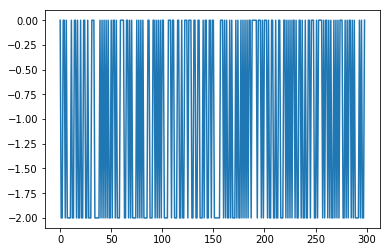

In [16]:
# We plot the difference between our model's predictions and the actual values:
plt.plot(y_test_vals - predictions)

In [17]:
from sklearn.linear_model import ElasticNet
